## **NASNetLarge Model**

### **1. Import the necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dropout,
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.regularizers import l2

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**

In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Building NasNetLarge Model**


In [3]:
# Function to create NASNetLarge model with customized top layers
def create_nasnetlarge_model(learning_rate, dropout_rate, dense_units):
    base_model = tf.keras.applications.NASNetLarge(
        weights="imagenet",  # Load weights pre-trained on ImageNet
        include_top=False,
        input_shape=(331, 331, 3),
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create new model on top
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(4, activation="softmax"))

    # Compile model with Adam optimizer and categorical crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **4. Train the Model**

In [4]:
# Define parameters
learning_rate = 0.0001
dropout_rate = 0.5
dense_units = 512
n_splits = 5
epochs = 300
batch_size = 16

# Initialize dictionary to store models and histories
models = {}

# Iterate over K-fold splits
for fold in range(n_splits):
    print(f"Fold {fold + 1}")

    # Define paths for current fold
    train_dir = f"kfold_dataset_331/train_fold_{fold}"
    val_dir = f"kfold_dataset_331/val_fold_{fold}"

    # ImageDataGenerator for data augmentation and normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Flow training images in batches using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(331, 331),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # Flow validation images in batches using val_datagen generator
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(331, 331),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
    )

    # Create and compile model
    model = create_nasnetlarge_model(
        learning_rate=learning_rate, dropout_rate=dropout_rate, dense_units=dense_units
    )

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        filepath=f"nasnetlarge_fold_{fold}.h5",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=30,
        restore_best_weights=True,
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1,
    )

    # Evaluate and store model performance
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    # Predict labels for validation set
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    models[fold] = {
        "model": model,
        "history": history.history,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        "conf_matrix": conf_matrix,
    }

# Save the best model
best_model_fold = max(models, key=lambda k: models[k]["val_accuracy"])
models[best_model_fold]["model"].save("best_nasnetlarge_model.h5")

Fold 1
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/300
24/24 [==============================] - ETA: 0s - loss: 1.5086 - accuracy: 0.3724
Epoch 1: val_accuracy improved from -inf to 0.67708, saving model to nasnetlarge_fold_0.h5
24/24 [==============================] - 18s 396ms/step - loss: 1.5086 - accuracy: 0.3724 - val_loss: 1.0032 - val_accuracy: 0.6771
Epoch 2/300
24/24 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.6276
Epoch 2: val_accuracy improved from 0.67708 to 0.73958, saving model to nasnetlarge_fold_0.h5
24/24 [==============================] - 6s 252ms/step - loss: 0.9336 - accuracy: 0.6276 - val_loss: 0.8345 - val_accuracy: 0.7396
Epoch 3/300
24/24 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.6693
Epoch 3: val_accuracy improved from 0.73958 to 0.75000, saving model to nasnetlarge_fold_0.h5
24/24 [==============================] - 6s 247ms/step - loss: 0.8257 - accuracy: 0.6

### **5. Evaluate and Visualize Results**

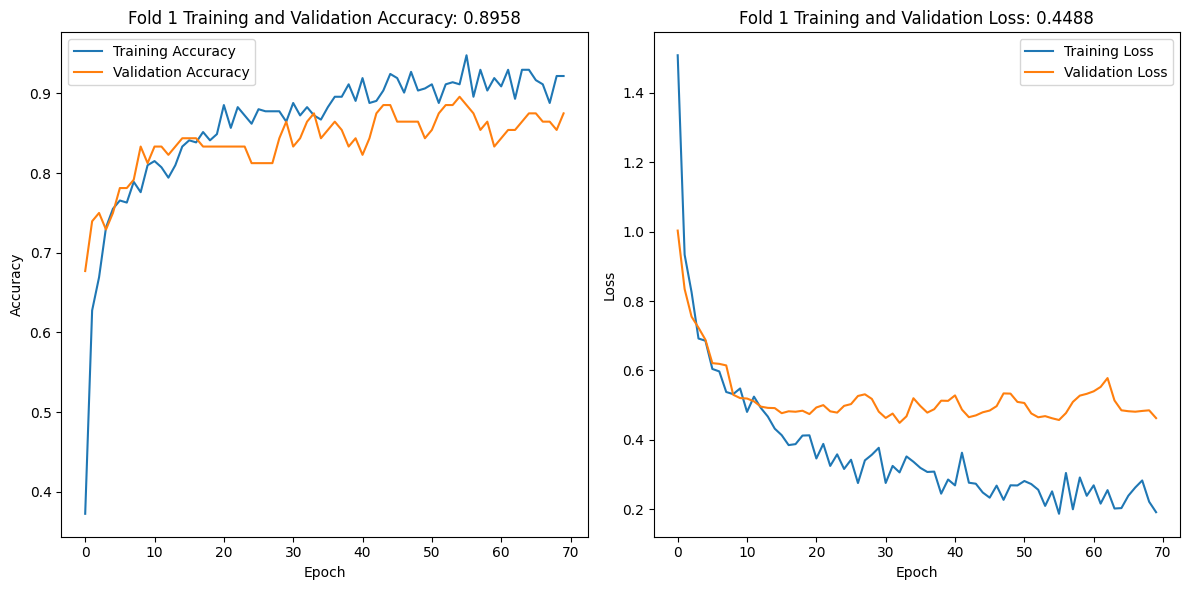

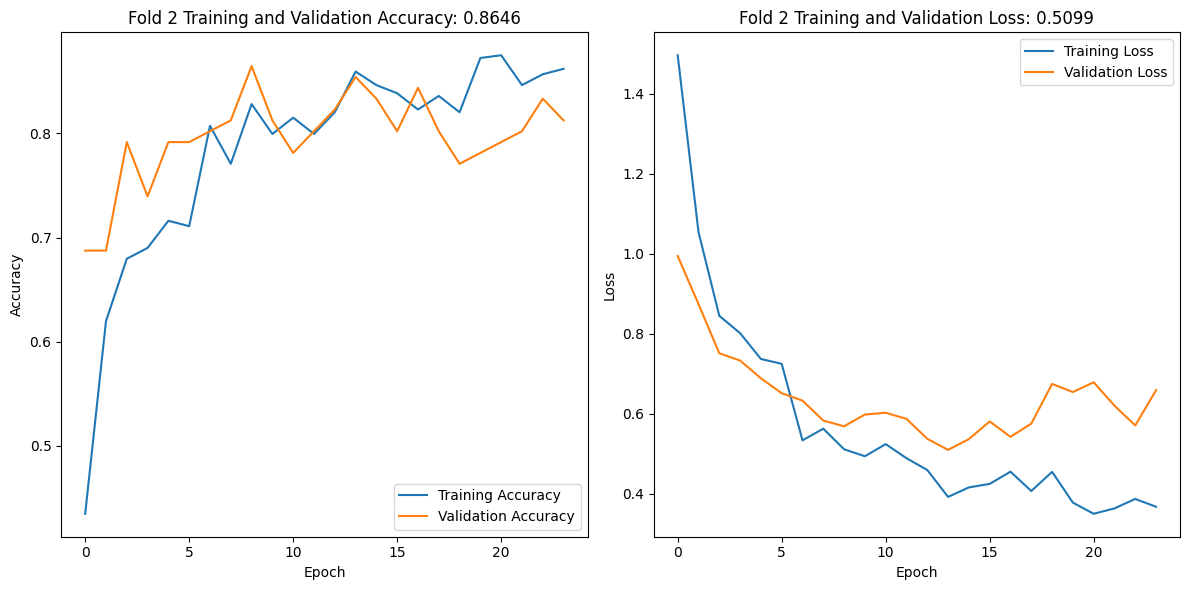

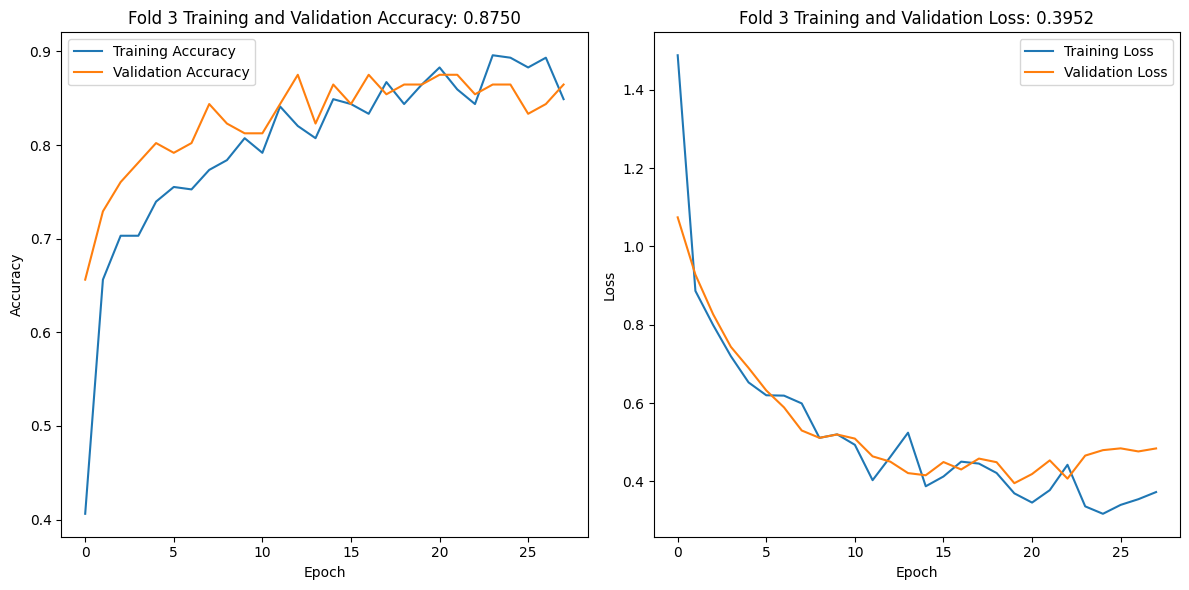

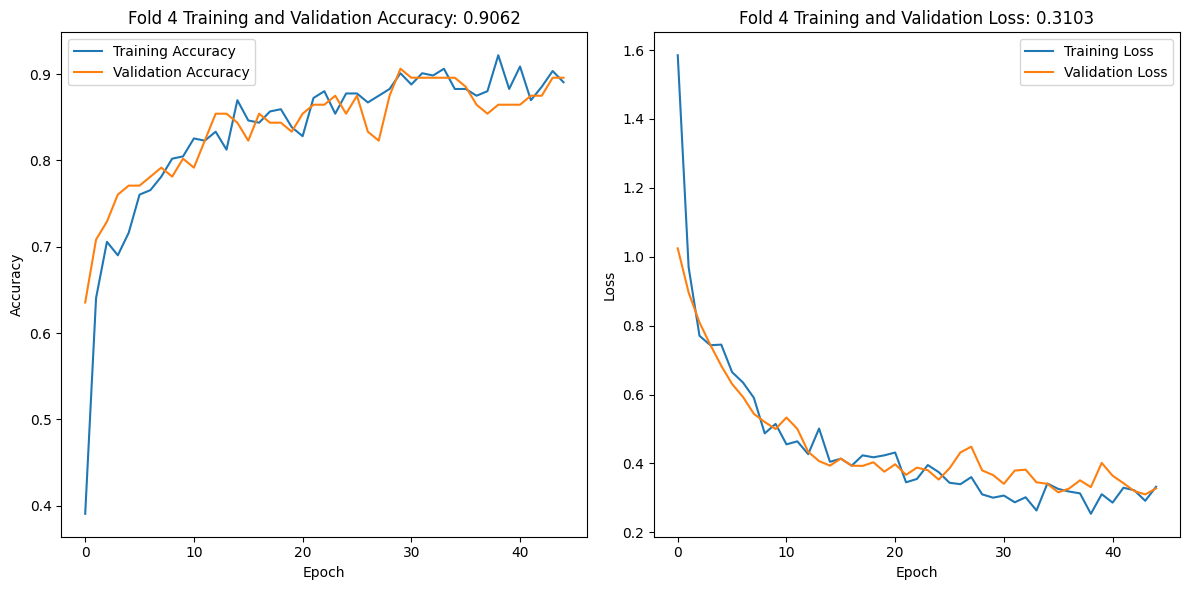

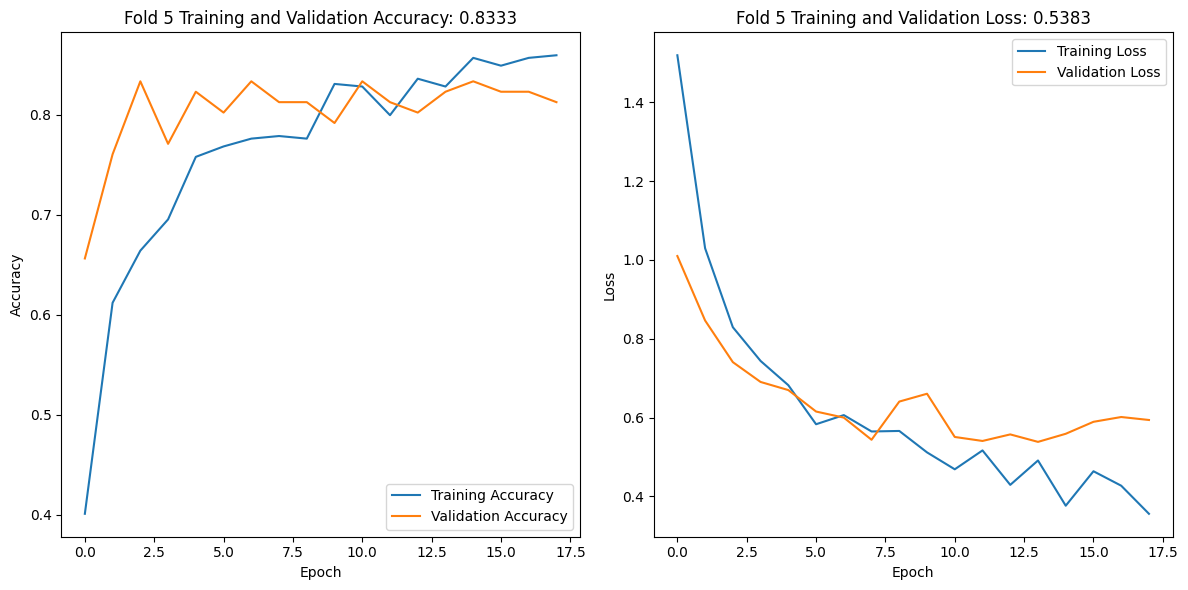

In [5]:
# Plot training history for all folds
for fold, result in models.items():
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(result["history"]["accuracy"], label="Training Accuracy")
    plt.plot(result["history"]["val_accuracy"], label="Validation Accuracy")
    plt.title(f"Fold {fold + 1} Training and Validation Accuracy: {result['val_accuracy']:.4f}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(result["history"]["loss"], label="Training Loss")
    plt.plot(result["history"]["val_loss"], label="Validation Loss")
    plt.title(f"Fold {fold + 1} Training and Validation Loss: {result['val_loss']:.4f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

Fold 1 - Accuracy: 0.8958 - Loss: 0.4488
Fold 1
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 121ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91        24
  meningioma       0.80      0.83      0.82        24
   pituitary       0.92      0.96      0.94        24
     notumor       0.92      0.92      0.92        24

    accuracy                           0.90        96
   macro avg       0.90      0.90      0.90        96
weighted avg       0.90      0.90      0.90        96



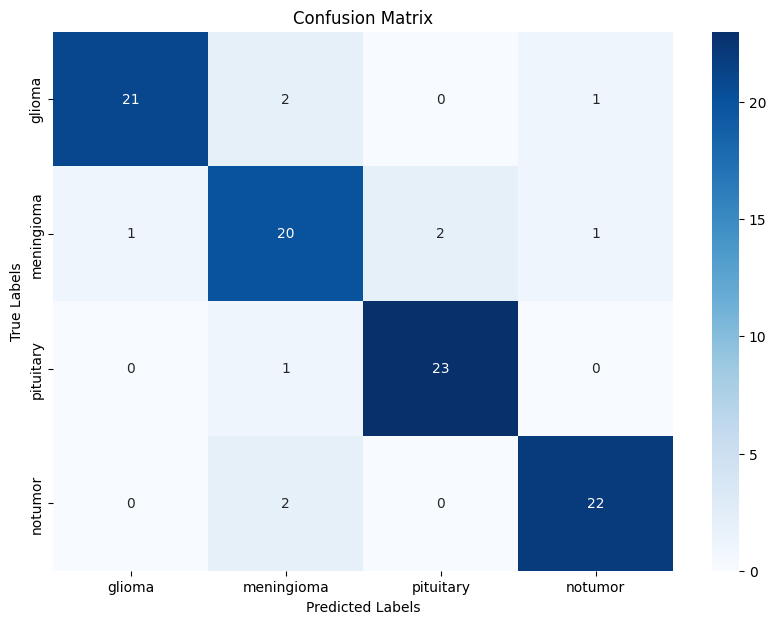

Fold 2 - Accuracy: 0.8646 - Loss: 0.5099
Fold 2
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 119ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.75      0.82        24
  meningioma       0.80      0.83      0.82        24
   pituitary       0.96      0.92      0.94        24
     notumor       0.82      0.96      0.88        24

    accuracy                           0.86        96
   macro avg       0.87      0.86      0.86        96
weighted avg       0.87      0.86      0.86        96



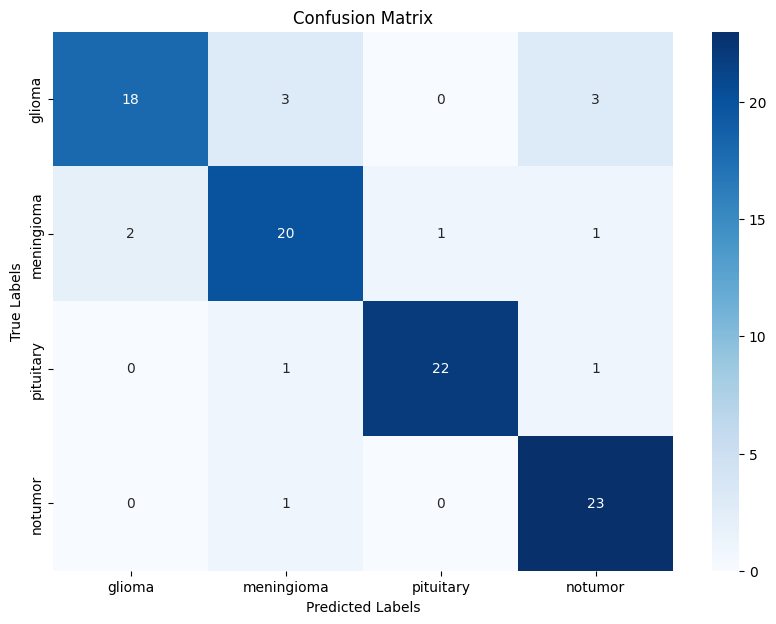

Fold 3 - Accuracy: 0.8750 - Loss: 0.3952
Fold 3
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 120ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.83      0.87        24
  meningioma       0.86      0.79      0.83        24
   pituitary       0.88      0.92      0.90        24
     notumor       0.85      0.96      0.90        24

    accuracy                           0.88        96
   macro avg       0.88      0.88      0.87        96
weighted avg       0.88      0.88      0.87        96



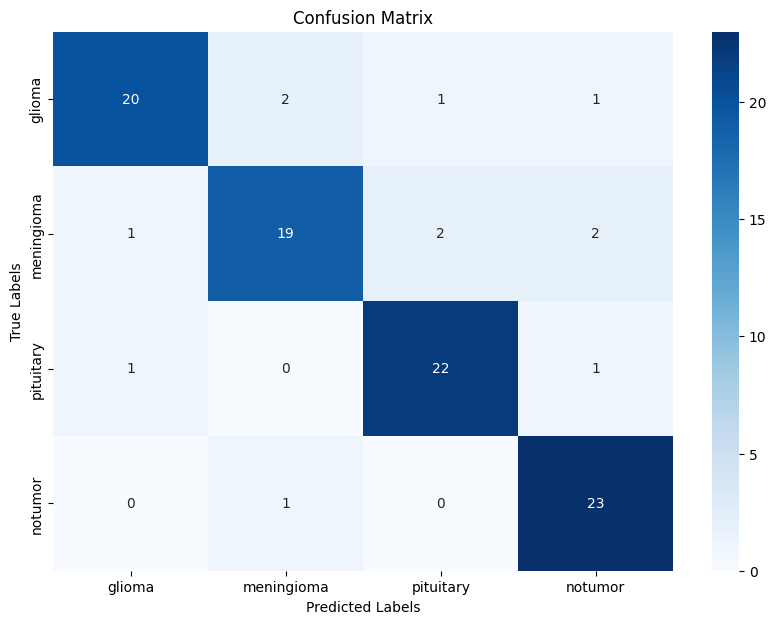

Fold 4 - Accuracy: 0.9062 - Loss: 0.3103
Fold 4
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 123ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.88      0.92      0.90        24
  meningioma       0.95      0.79      0.86        24
   pituitary       0.88      0.92      0.90        24
     notumor       0.92      1.00      0.96        24

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.90        96
weighted avg       0.91      0.91      0.90        96



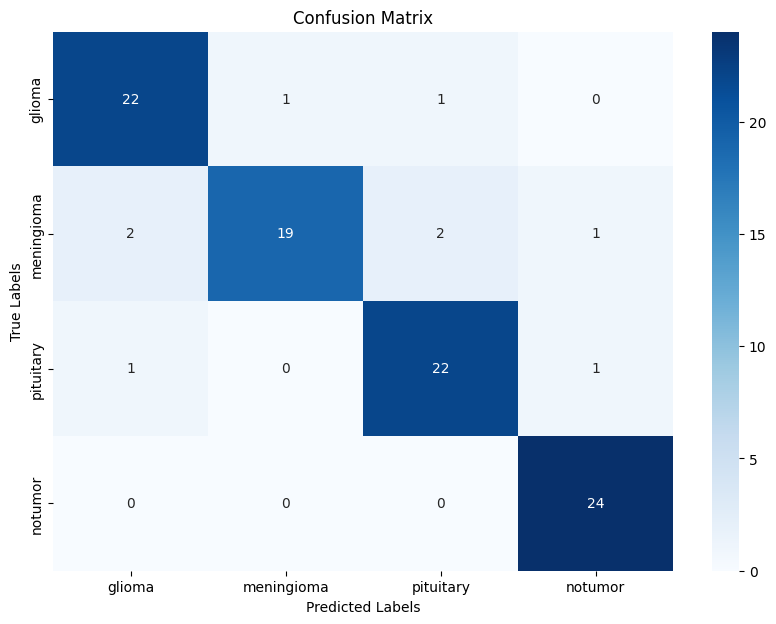

Fold 5 - Accuracy: 0.8333 - Loss: 0.5383
Fold 5
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 120ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.79      0.84        24
  meningioma       0.81      0.71      0.76        24
   pituitary       0.88      0.88      0.88        24
     notumor       0.77      0.96      0.85        24

    accuracy                           0.83        96
   macro avg       0.84      0.83      0.83        96
weighted avg       0.84      0.83      0.83        96



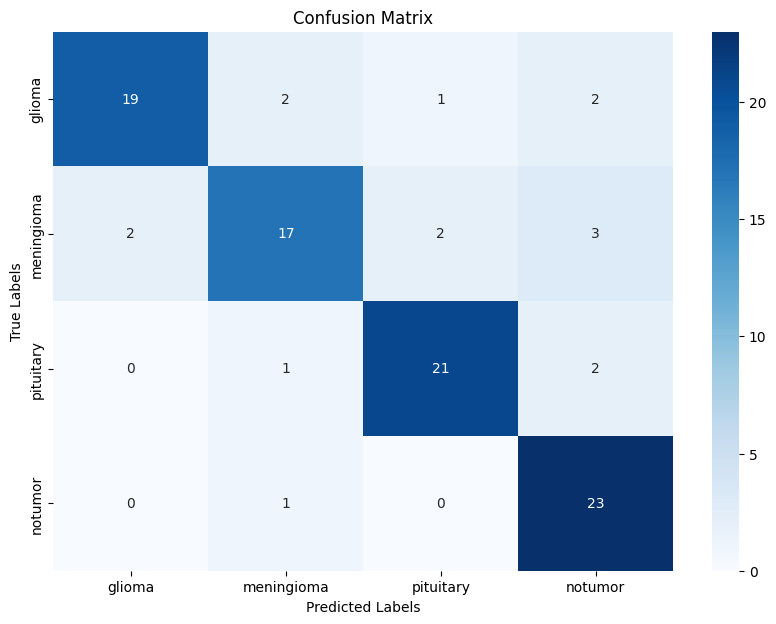

In [6]:
# Load the saved model
image_size = 331
for key, value in models.items():
    accuracy = value["val_accuracy"]
    loss = value["val_loss"]
    model = value["model"]
    print(f"Fold {key + 1} - Accuracy: {accuracy:.4f} - Loss: {loss:.4f}")
    print(f"Fold {key + 1}")

    # Define the paths
    data_dir = "../DATASETS/kfold_dataset_331"
    val_dir = data_dir + f"/val_fold_{key}"

    # ImageDataGenerator for normalization
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Data generator for test set
    test_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(
            image_size,
            image_size,
        ),  # Adjust if your model was trained with a different target size
        batch_size=16,  # Adjust based on your batch size during training
        class_mode="categorical",
        shuffle=False,
    )
    categories = ["glioma", "meningioma", "pituitary", "notumor"]

    # Predict the labels for the test set
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Compute the classification report
    report = classification_report(y_true, y_pred_classes, target_names=categories)
    print("Classification Report:\n")
    print(report)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=categories,
        yticklabels=categories,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()